# Graph Analysis
### Betweenness centrality
**Betweenness centrality** measures how often a node lies on the shortest paths between other nodes in a network.
- Nodes with high betweenness act as bridges or bottlenecks that control information/resource flow.
- It identifies critical nodes whose removal would most disrupt network connectivity, making it essential for understanding control points and vulnerability in networks

**Hint 1:** To compute betweenness we use **Brandes' algorithm**.
<br>**Hint2:** For finding shortest paths, in unweighted graphs, we use **breadth-first search** (BFS) and in weighted graphs, we use **Dijkstra's algorithm**.
<hr>

In the following:
- We first introduce a function to compute betweenness centrality with BFS for unweighted graphs. Then, we test it by a graph with bridge node, and a simple social network. after that, we test it by the Zachary's karate club network. We display all three graphs by **NetworkX** and helper functions. 
- As a bonus, we implmeent a function to compute betweeness centrality with Dijkstra's algorithm for weighted graphs. Finally, we test it by a directed weighted transport network.

https://github.com/ostad-ai/Graph-Analysis
<br>Explanation in English :https://www.pinterest.com/HamedShahHosseini/graph-analysis/

In [1]:
# Import required modules
import heapq
import networkx as nx
from collections import deque
import matplotlib.pyplot as plt

In [2]:
def betweenness_centrality_bfs(adj_list, normalized=True, directed=False):
    """
    Betweenness centrality implementation
    Parameters:
    - adj_list: adjacency list representation
    - normalized: whether to normalize scores
    - directed: whether the graph is directed
    """
    nodes = list(adj_list.keys())
    n = len(nodes)
    
    betweenness = {node: 0.0 for node in nodes}
    
    for source in nodes:
        dist = {node: -1 for node in nodes}
        sigma = {node: 0 for node in nodes}
        pred = {node: [] for node in nodes}
        stack = []
        queue = deque()
        
        dist[source] = 0
        sigma[source] = 1
        queue.append(source)
        
        while queue:
            current = queue.popleft()
            stack.append(current)
            
            for neighbor in adj_list[current]:
                # First time discovering this node
                if dist[neighbor] == -1:
                    dist[neighbor] = dist[current] + 1
                    queue.append(neighbor)
                    sigma[neighbor] = sigma[current] # Initialize with current's paths
                    pred[neighbor].append(current)
                
                # Already discovered, but found another shortest path at same distance
                elif dist[neighbor] == dist[current] + 1:
                    sigma[neighbor] += sigma[current]
                    pred[neighbor].append(current)
        
        # Accumulation phase
        delta = {node: 0 for node in nodes}
        
        while stack:
            current = stack.pop()
            for predecessor in pred[current]:
                if sigma[current] > 0:
                    delta[predecessor] += (sigma[predecessor] / sigma[current]) * (1 + delta[current])
            
            if current != source:
                betweenness[current] += delta[current]
    
    # For undirected graphs, divide by 2
    if not directed:
        betweenness = {node: score / 2 for node, score in betweenness.items()}
    
    # Standard normalization
    if normalized and n > 2:
        if directed:
            normalization = (n - 1) * (n - 2)
        else:
            normalization = (n - 1) * (n - 2) / 2
        betweenness = {node: score / normalization for node, score in betweenness.items()}
    
    return betweenness

In [3]:
# Example
bridge_network = {
        'A': ['B'],
        'B': ['A', 'C', 'D'],  # Bridge node
        'C': ['B', 'E', 'F'],
        'D': ['B', 'G', 'H'],
        'E': ['C'],
        'F': ['C'],
        'G': ['D'],
        'H': ['D']
    }
betweenness_bridge = betweenness_centrality_bfs(bridge_network, normalized=True)    
print("Betweenness Centrality for bridge network:")
for node, score in sorted(betweenness_bridge.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {score:.4f}")
    

Betweenness Centrality for bridge network:
Node B: 0.7143
Node C: 0.5238
Node D: 0.5238
Node A: 0.0000
Node E: 0.0000
Node F: 0.0000
Node G: 0.0000
Node H: 0.0000


In [4]:
# Example: Social network
social_network = {
        'Alice': ['Bob', 'Charlie', 'Diana'],
        'Bob': ['Alice', 'Charlie', 'Eve'],
        'Charlie': ['Alice', 'Bob', 'Diana', 'Frank'],
        'Diana': ['Alice', 'Charlie', 'Grace'],
        'Eve': ['Bob', 'Frank', 'Helen'],
        'Frank': ['Charlie', 'Eve', 'Grace', 'Helen'],
        'Grace': ['Diana', 'Frank', 'Ian'],
        'Helen': ['Eve', 'Frank', 'Ian'],
        'Ian': ['Grace', 'Helen']
    }
betweenness_social = betweenness_centrality_bfs(social_network, normalized=True)
print("Betweenness Centrality for social network:")
for node, score in sorted(betweenness_social.items(), key=lambda x: x[1], reverse=True):
    print(f"{node:8}: {score:.4f}")

Betweenness Centrality for social network:
Frank   : 0.2262
Grace   : 0.1637
Charlie : 0.1548
Diana   : 0.1190
Eve     : 0.1161
Helen   : 0.1012
Bob     : 0.0893
Alice   : 0.0357
Ian     : 0.0298


<hr style="height:3px;background-color:orange">

# Helper functions
### Helper functions to display graphs with NetworkX

In [5]:
# Helper functions to draw the graphs 
def networkx_to_adjacency(nx_graph, weighted=False):
    """
    Convert NetworkX graph to adjacency list with weighted and directed options
    Parameters:
    - nx_graph: NetworkX graph object
    - weighted: if True, include edge weights
    Returns:
    - adj_list: adjacency list representation
    """
    adj_list = {}
    
    for node in nx_graph.nodes():
        if weighted:
            # For weighted graphs: {neighbor: weight}
            adj_list[node] = {}
            for neighbor, edge_data in nx_graph[node].items():
                weight = edge_data.get('weight', 1.0)  # Default weight = 1 if not specified
                adj_list[node][neighbor] = weight
        else:
            # For unweighted graphs: list of neighbors
            adj_list[node] = list(nx_graph.neighbors(node))
    return adj_list

#--------------------

def adjacency_to_networkx(adj_list,weighted=False,directed=False):
    """
    Convert adjacency list to NetworkX graph for visualization
    """
    if directed:
        G=nx.DiGraph()
    else:
        G = nx.Graph()
        
    for node, neighbors in adj_list.items():
        if weighted and isinstance(neighbors, dict):
            # Weighted graph: neighbors is {neighbor: weight}
            for neighbor, weight in neighbors.items():
                G.add_edge(node, neighbor, weight=weight)
        else:
            # Unweighted graph: neighbors is list
            for neighbor in neighbors:
                G.add_edge(node, neighbor)
    
    return G

In [6]:
# Example Zachary's karate club
# Load the network
G_kc = nx.karate_club_graph()

# Convert to adjacency list
adj_list_kc = networkx_to_adjacency(G_kc)
betweenness_kc = betweenness_centrality_bfs(adj_list_kc, normalized=True)
print("Betweenness Centrality for karate club network:")
for node, score in sorted(betweenness_kc.items(), key=lambda x: x[1], reverse=True):
    print(f"{node:2}: {score:.4f}",end=', ')
    
# # comparison with betweneness of NetWorkX
# bc_nx=sorted(nx.betweenness_centrality(G_kc).items(), key=lambda x: x[1],reverse=True)
# print('\n---Results from Betweeness of Networkx---')
# for node, score in bc_nx:
#     print(f"{node:2}: {score:.4f}",end=', ')

Betweenness Centrality for karate club network:
 0: 0.4376, 33: 0.3041, 32: 0.1452,  2: 0.1437, 31: 0.1383,  8: 0.0559,  1: 0.0539, 13: 0.0459, 19: 0.0325,  5: 0.0300,  6: 0.0300, 27: 0.0223, 23: 0.0176, 30: 0.0144,  3: 0.0119, 25: 0.0038, 29: 0.0029, 24: 0.0022, 28: 0.0018,  9: 0.0008,  4: 0.0006, 10: 0.0006,  7: 0.0000, 11: 0.0000, 12: 0.0000, 14: 0.0000, 15: 0.0000, 16: 0.0000, 17: 0.0000, 18: 0.0000, 20: 0.0000, 21: 0.0000, 22: 0.0000, 26: 0.0000, 

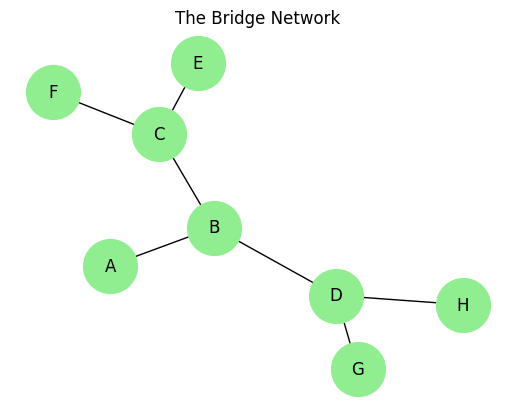

In [7]:
# THe graph of bridge_network 
G_bridge=adjacency_to_networkx(bridge_network)
plt.title('The Bridge Network')
nx.draw(G_bridge,with_labels=True,node_size=1500,node_color='lightgreen')

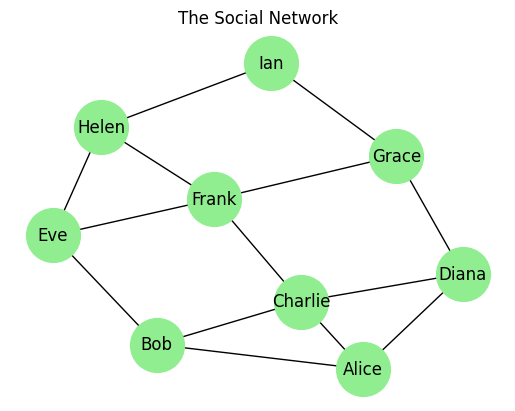

In [8]:
# THe graph of social_network 
G_social=adjacency_to_networkx(social_network)
plt.title('The Social Network')
nx.draw(G_social,with_labels=True,node_size=1500,node_color='lightgreen')

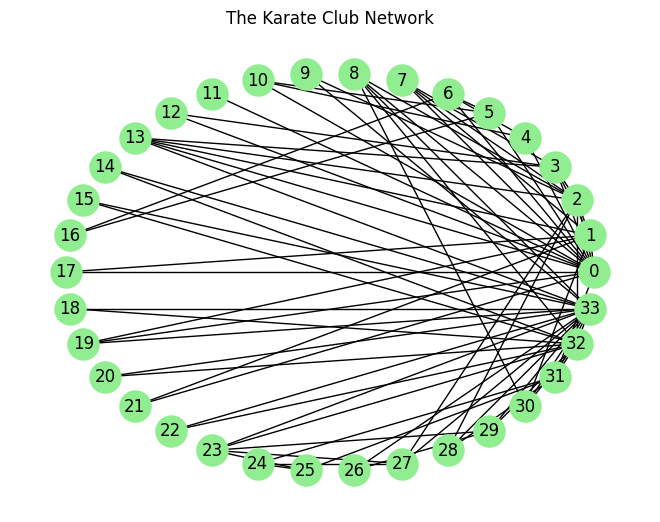

In [9]:
# THe graph of karate club 
pos=nx.circular_layout(G_kc,scale=3)
nx.draw(G_kc,pos,with_labels=True,node_size=500,node_color='lightgreen')
plt.title('The Karate Club Network')
plt.show()

<hr style="height:3px;background-color:lightgreen">

# Bonus
### Betweenness centrality for weightd graphs

In [10]:
def betweenness_centrality_weighted(adj_list, normalized=True, directed=False):
    """
    Weighted betweenness centrality implementation
    
    Parameters:
    - adj_list: dict where adj_list[node] = {neighbor: weight}
    - normalized: whether to normalize scores
    - directed: whether the graph is directed
    
    Returns:
    - dict: node -> betweenness centrality
    """
    nodes = list(adj_list.keys())
    n = len(nodes)
    
    betweenness = {node: 0.0 for node in nodes}
    
    for source in nodes:
        # Data structures for Dijkstra
        dist = {node: float('inf') for node in nodes}
        sigma = {node: 0 for node in nodes}
        pred = {node: [] for node in nodes}
        stack = []
        
        # Initialize source
        dist[source] = 0
        sigma[source] = 1
        
        # Priority queue: (distance, node)
        pq = [(0, source)]
        
        # Dijkstra's algorithm
        while pq:
            current_dist, current = heapq.heappop(pq)
            
            # Skip if we found a better path already
            if current_dist > dist[current]:
                continue
                
            stack.append(current)
            
            # Explore neighbors
            for neighbor, weight in adj_list[current].items():
                new_dist = dist[current] + weight
                
                if new_dist < dist[neighbor]:
                    # Found shorter path
                    dist[neighbor] = new_dist
                    sigma[neighbor] = sigma[current]
                    pred[neighbor] = [current]
                    heapq.heappush(pq, (new_dist, neighbor))
                elif new_dist == dist[neighbor]:
                    # Found another shortest path at same distance
                    sigma[neighbor] += sigma[current]
                    pred[neighbor].append(current)
        
        # Accumulation - backward from farthest nodes
        delta = {node: 0 for node in nodes}
        
        # Process nodes in reverse order of discovery (farthest first)
        while stack:
            current = stack.pop()
            for predecessor in pred[current]:
                if sigma[current] > 0:  # Avoid division by zero
                    delta[predecessor] += (sigma[predecessor] / sigma[current]) * (1 + delta[current])
            
            if current != source:
                betweenness[current] += delta[current]
    
    # KEY CORRECTION: For undirected graphs, divide by 2
    if not directed:
        betweenness = {node: score / 2 for node, score in betweenness.items()}
    
    # Standard normalization
    if normalized and n > 2:
        if directed:
            normalization = (n - 1) * (n - 2)
        else:
            normalization = (n - 1) * (n - 2) / 2
        betweenness = {node: score / normalization for node, score in betweenness.items()}
    
    return betweenness

In [11]:
# Example of weighted directed graph
directed_transport = {
    'Home': {'Work': 30, 'School': 15},
    'Work': {'Airport': 45, 'Home': 30},  # Can return home
    'School': {'Mall': 5, 'Home': 15},
    'Mall': {'Stadium': 25},
    'Airport': {'Stadium': 60},
    'Stadium': {}  # Dead end - no outgoing roads
}
bcw_dt=betweenness_centrality_weighted(directed_transport,normalized=True, directed=True)
for node, score in sorted(bcw_dt.items(),key=lambda x:x[1],reverse=True):
    print(f"{node:2}: {score:.4f}",end=', ')

Home: 0.2500, School: 0.2000, Mall: 0.1500, Work: 0.1000, Airport: 0.0000, Stadium: 0.0000, 

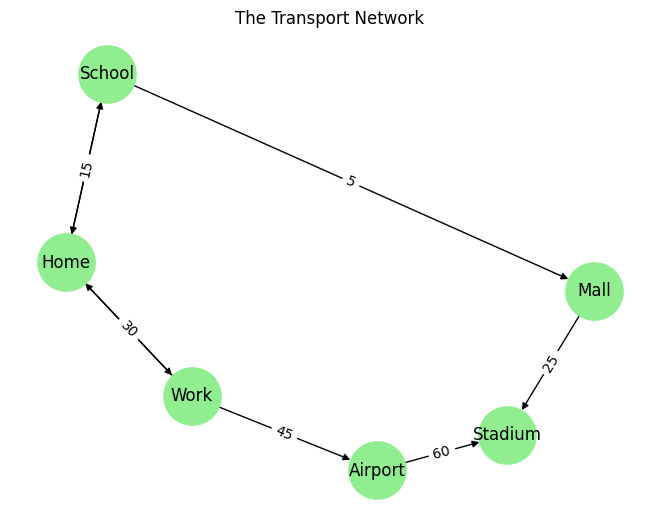

In [13]:
# THe graph of directed_transport 
G_transport=adjacency_to_networkx(directed_transport,weighted=True,directed=True)
pos=nx.spring_layout(G_transport,k=1.5)
nx.draw(G_transport,pos,with_labels=True,node_size=1700,node_color='lightgreen')
labels_transport = nx.get_edge_attributes(G_transport,'weight')
nx.draw_networkx_edge_labels(G_transport,pos,edge_labels=labels_transport)
plt.title('The Transport Network')
plt.show()